In [97]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

In [2]:
def create_test_graph():
    G = nx.Graph()
    G.add_node(0)
    G.add_nodes_from(range(1,23))
    G.add_edge(0, 9)
    G.add_edges_from([(0, 11), (1, 2), (1, 19), (1, 20), (1, 2), (2, 8), (3, 8), (4, 14),
                      (4, 16), (4, 17), (4, 18), (5, 10), (5, 13), (5, 16), (5, 17), (6, 7),
                      (6, 8), (6, 10), (6, 14), (6, 13), (7, 8), (8, 9), (8, 10), (9, 10),
                      (10, 11), (10, 14), (11, 12), (11, 15), (11, 18), (13, 14), (14, 16), (14, 18),
                      (15, 18), (15, 19), (15, 20), (15, 21), (16, 17), (17, 22), (18, 19), (18, 8),
                      (19, 8), (20, 21), (22, 8)])
    return G

In [3]:
def random_binomial_graph(n, p=0.5):
    G = nx.generators.binomial_graph(n, p)
    while nx.is_connected(G) is False:
        G = nx.generators.binomial_graph(n, p)
    return G

In [4]:
def create_complete_graph(G):
    return nx.complete_graph(G.nodes)

In [5]:
def test():
    G = create_test_graph()
    print(G.nodes)
    print(G.edges)
    G[21][15]["weight"] = 1

    pos = nx.spring_layout(G)
    nx.draw(G, with_labels=True, pos=pos)
    labels = nx.get_edge_attributes(G, "weight")
    print(labels)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.savefig('test_graph.pdf')
    plt.show()

In [6]:
def test_spanning_tree():
    G = create_test_graph()
    for u, v in G.edges:
        G[u][v]["weight"] = random.randint(1, 10)
    T = nx.algorithms.maximum_spanning_tree(G, weight="weight")
    print(T)

    plt.subplot(121)
    pos = nx.spring_layout(G)
    nx.draw(G, with_labels=True, pos=pos)

    plt.subplot(122)
    nx.draw(T, with_labels=True, pos=pos)
    plt.savefig('test_minimum_tree.pdf')
    plt.show()

In [7]:
def test_shortest_paths():
    G = create_test_graph()
    for u, v in G.edges:
        G[u][v]["weight"] = random.randint(1, 10)

    distances = dict(nx.algorithms.all_pairs_dijkstra_path_length(G, weight="weight"))

    pos = nx.spring_layout(G)
    nx.draw(G, with_labels=True, pos=pos)
    labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.savefig('test_shortest_paths.pdf')
    plt.show()

    print(distances[0])
    print(distances[0][22])

In [8]:
# verify if a solution is correct and evaluate it
def eval_sol(graph, terminals, sol) -> float:
    graph_sol = nx.Graph()
    for (i, j) in sol:
        if (i, j) in graph_sol.edges:
            graph_sol[i][j]['weight'] = 1 + graph_sol[i][j].get('weight', 1)
        else:
            graph_sol.add_edge(i, j, weight=graph[i][j].get('weight', 1))

    if not nx.is_tree(graph_sol):
        print ("Error: the proposed solution is not a tree")
        return -1

    for i in terminals:
        if not i in graph_sol:
            print ("Error: a terminal is missing from the solution")
            return -1

    cost = graph_sol.size(weight='weight')
    return cost

In [12]:
def two_approximation(G, terms):
    # Step 1: Create the complete graph K using shortest paths between all terminal pairs
    K = nx.Graph()
    shortest_paths = {}
    for u in terms:
        for v in terms:
            if u != v:
                length, path = nx.single_source_dijkstra(G, u, target=v)
                K.add_edge(u, v, weight=length)
                shortest_paths[(u, v)] = path

    # Step 2: Compute the Minimum Spanning Tree A from graph K
    A = nx.minimum_spanning_tree(K, algorithm="kruskal")

    # Step 3: Unfold shortest path edges in G for each edge (u, v) in A
    steiner_edges = []
    for u, v in A.edges():
        path = shortest_paths[(u, v)]
        
        for i in range(len(path) - 1):
            steiner_edges.append((path[i], path[i + 1]))

    return steiner_edges

In [13]:
sol = two_approximation(create_test_graph(),[0, 1, 2, 3, 4])
sol

[(0, 9), (9, 8), (8, 2), (0, 11), (11, 18), (18, 4), (1, 2), (2, 8), (8, 3)]

In [14]:
eval_sol(create_test_graph(),[0, 1, 2, 3, 4],sol)

9.0

In [15]:
def create_graphs(n,s,model,**kwargs):
    Graphs = []
    while len(Graphs) < n:
        G = model(s,**kwargs)
        while nx.is_connected(G) is False:
            G = model(s,**kwargs)
        Graphs.append(G)
    return Graphs

In [211]:
graph_series = create_graphs(5, 10, nx.generators.binomial_graph, p=0.5)

In [94]:
def average_solution(Graphs,f,terms):
    total_weight = 0
    for G in Graphs:
        weight = eval_sol(G,terms,f(G,terms))
        total_weight += weight
    average_weight = total_weight / len(Graphs)
    return average_weight

In [104]:
 def three_terminal_steiner_tree(G, t0, t1, t2):
    # Step 1: Compute shortest paths between all pairs of terminals
    dist_01, path_01 = nx.single_source_dijkstra(G, t0, target=t1, weight='weight')
    dist_02, path_02 = nx.single_source_dijkstra(G, t0, target=t2, weight='weight')
    dist_12, path_12 = nx.single_source_dijkstra(G, t1, target=t2, weight='weight')
    
    # Step 2: Try all possible ways to connect the terminals via paths through intermediate nodes
    path_t0_t1 = path_01
    path_t2_to_path_01 = nx.shortest_path(G, source=t2, target=path_t0_t1[-1], weight='weight')
    tree_1 = path_t0_t1 + path_t2_to_path_01[1:]
    
    path_t0_t2 = path_02
    path_t1_to_path_02 = nx.shortest_path(G, source=t1, target=path_t0_t2[-1], weight='weight')
    tree_2 = path_t0_t2 + path_t1_to_path_02[1:]
    
    path_t1_t2 = path_12
    path_t0_to_path_12 = nx.shortest_path(G, source=t0, target=path_t1_t2[-1], weight='weight')
    tree_3 = path_t1_t2 + path_t0_to_path_12[1:]
    
    # Step 3: Compare all three options and return the one with the least cost
    total_cost_1 = sum(G[u][v].get('weight', 1) for u, v in zip(tree_1[:-1], tree_1[1:]))
    total_cost_2 = sum(G[u][v].get('weight', 1) for u, v in zip(tree_2[:-1], tree_2[1:]))
    total_cost_3 = sum(G[u][v].get('weight', 1) for u, v in zip(tree_3[:-1], tree_3[1:]))

    
    if total_cost_1 <= total_cost_2 and total_cost_1 <= total_cost_3:
        return total_cost_1, tree_1
    elif total_cost_2 <= total_cost_1 and total_cost_2 <= total_cost_3:
        return total_cost_2, tree_2
    else:
        return total_cost_3, tree_3 

In [105]:
 def lower_bound_k_terminal_steiner(G, terms):
    if len(terms) == 3:
        return three_terminal_steiner_tree(G, terms[0], terms[1], terms[2])
    
    # Use combinations of triples to estimate the lower bound
    min_bound = float('inf')
    for comb in combinations(terms, 3):
        bound = three_terminal_steiner_tree(G, comb[0], comb[1], comb[2])
        min_bound = min(min_bound, bound)
    
    return min_bound 

In [106]:
def average_lower_bound_k_terminal_steiner(graph_series,terms):
    total_bound = 0
    for G in graph_series:
        lb = lower_bound_k_terminal_steiner(G, terms)
        total_bound += lb
    average_bound = total_bound / len(graph_series)
    return average_bound

In [107]:
def lower_bound_shortest_path(G,terms):
    shortest_path_bound = 0
    for i in range(len(terms)):
        for j in range(i + 1, len(terms)):
            path_length = nx.shortest_path_length(G, source=terms[i], target=terms[j], weight='weight')
            shortest_path_bound = max(shortest_path_bound, path_length)
    return shortest_path_bound

In [108]:
def average_lower_bound_shortest_path(graph_series,terms):
    total_bound = 0
    for G in graph_series:
        lb = lower_bound_shortest_path(G, terms)
        total_bound += lb
    average_bound = total_bound / len(graph_series)
    return average_bound

In [109]:
def plot_average_solution_vs_parameter(parameter_values,n,s,model,f,terms,**kwargs):
    average_weights = []
    average_short_path_bounds = []
    average_k_terms_bounds = []
    for value in parameter_values:
        kwargs['p'] = value
        graph_series = create_graphs(n, s, model, **kwargs)
        average_weight = average_solution(graph_series, f, terms)
        average_short_path_bound = average_lower_bound_shortest_path(graph_series, terms)
        average_k_term_bound = average_lower_bound_k_terminal_steiner(graph_series, terms)
        average_weights.append(average_weight)
        average_short_path_bounds.append(average_short_path_bound)
        average_k_terms_bounds.append(average_k_term_bound)

    plt.plot(parameter_values, average_weights, marker='o', label='Apprix')
    plt.plot(parameter_values, average_short_path_bounds, marker='x', linestyle='--', label='Bound shortest path')
    plt.plot(parameter_values, average_k_terms_bounds, marker='x', linestyle='--', label='Bound k terminals')
    plt.xlabel('Parameter Value (p)')
    plt.ylabel('Average Weight')
    plt.title(f'random binomial graph - Size of graphs : {s} nodes')
    plt.legend()
    plt.grid(True)
    plt.show()

In [110]:
def generate_random_terminals(T, N):
    if N < 2:
        raise ValueError("N must be at least 2.")
    if T > N:
        raise ValueError("T must be less than or equal to N.")
    
    elements = random.sample(range(N), N)
    
    result = elements[:T]
    
    return result

In [111]:
def plot_average_solution_vs_terminals(n,s,model,f,**kwargs):
    average_weights = []
    average_bounds = []
    percentages = [0] + [p / 100 for p in range(10, 101, 10)]
    graph_series = create_graphs(n, s, model, **kwargs)
    for percentage in percentages:
        num_terminals = max(2, int(s * percentage))
        terminals = generate_random_terminals(num_terminals, s)
        average_weight = average_solution(graph_series, f, terminals)
        average_bound = average_lower_bound_shortest_path(graph_series, terminals)
        average_weights.append(average_weight)
        average_bounds.append(average_bound)

    plt.plot([p * 100 for p in percentages], average_weights, marker='o', label='Apprix')
    plt.plot([p * 100 for p in percentages], average_bounds,  marker='x', linestyle='--', label='Bound shortest path')
    plt.xlabel('Percentage of terminals')
    plt.ylabel('Average Weight')
    plt.title(f'random binomial dense graph - Size of graphs : {s} nodes')
    plt.legend()
    plt.grid(True)
    plt.show()

In [112]:
graph_series = create_graphs(5, 10, nx.generators.binomial_graph, p=0.5)
terminals = [0, 1, 2, 3, 4]
average_weight = average_solution(graph_series, two_approximation, terminals)
average_l_bound = average_lower_bound(graph_series, terminals)
print(f"Average Lower Bound: {average_l_bound}")
print(f"Average Steiner Tree weight: {average_weight}")

Average Lower Bound: 3.8
Average Steiner Tree weight: 4.6


In [113]:
parameter_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nb_graphs = 50
nb_nodes = 50
terminals = generate_random_terminals(30, 50)
plot_average_solution_vs_parameter(parameter_values, nb_graphs, nb_nodes, nx.generators.binomial_graph, two_approximation, terminals)

KeyError: 10

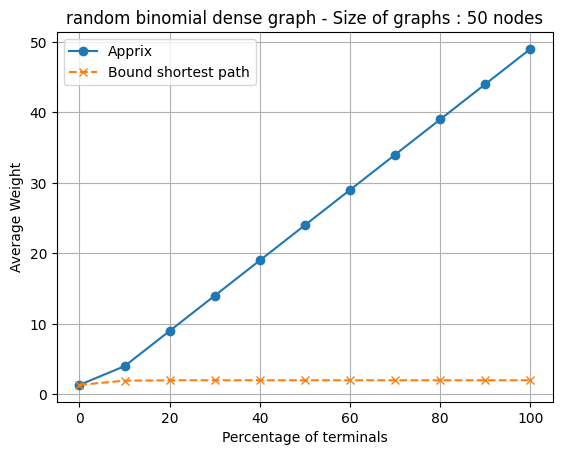

In [93]:
nb_graphs = 50
nb_nodes = 50
plot_average_solution_vs_terminals(nb_graphs,nb_nodes,nx.generators.binomial_graph,two_approximation, p = 0.7)